## Multilabel Multiclass classification

This notebook tries to model the dataset using Multilabel Multiclass classification.
- all the labels except primary_label is used as multi label input (note: primary_label is already taken into account in this set). 
- in this notebook, we first try different classifiers (with default parameters) and compare their accuracy performance. We then evaluate the performance of the best performing classifier using GridSearchCV.
- before classification, we preprocess the data using class:classifier. features are representing using tfidf method and chi2 method is used for feature selection.

#### import statements

In [84]:
from classes.Classifiers.Classifiers import Classifiers
from classes.Classifiers.ClassBalancer import ClassBalancer
from classes.Classifiers.FeatureSelector import FeatureSelector
from classes.Classifiers.ModelComparison import ModelComparison
from classes.Utils.PandasUtils import PandasUtils

In [85]:
#numerical
import numpy as np
import pandas as pd
import math
from glob import glob 

#os related operations
import os 
from os import listdir
from os.path import isfile, join

#data structures
from collections import Counter
from itertools import chain
from itertools import islice

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [86]:
#sklearn
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.feature_selection import SelectKBest, chi2,f_classif 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve  

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC #multiclass
from sklearn.linear_model import LogisticRegression #multiclass
from sklearn.ensemble import RandomForestClassifier #multilabel, multioutput
from sklearn.tree import DecisionTreeClassifier  #multilabel, multioutput
from sklearn.ensemble import GradientBoostingClassifier #multiclass

#### set path

In [87]:
path = os.getcwd()
results_path = os.path.join(path,'results','multi-label-classification','')
features_path = os.path.join(path,'features','')

In [88]:
if os.path.exists(results_path):
    pass
else:
    os.mkdir(results_path)

In [172]:
# results are stored in a dict
subset_acc_default = {}
hamming_loss_default = {}
f1score_default = {}
jaccard_default = {}

In [173]:
content='code'
setting = '_'+content+'_'+'scaled'
settings = [m+setting for m in ['rf','dt','gb','lsvc','svc','log'] ]

for model_name in settings:
    jaccard_default[model_name] = {}
    f1score_default[model_name] = {}
    subset_acc_default[model_name] = {}
    hamming_loss_default[model_name] = {}

#### load data

In [91]:
test_features = pd.read_pickle(features_path+'test_features.pkl')
train_features = pd.read_pickle(features_path+'train_features.pkl')
validation_features = pd.read_pickle(features_path+'validation_features.pkl')

train_features.index = range(train_features.shape[0])
validation_features.index = range(validation_features.shape[0])
test_features.index = range(test_features.shape[0])

train_features.fillna(0,inplace=True)
test_features.fillna(0,inplace=True)
validation_features.fillna(0,inplace=True)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

(5833, 32)
(1927, 32)
(1918, 32)


#### labels

In [92]:
labels = ['helper_functions','load_data',
              'data_preprocessing','data_exploration',
              'modelling','evaluation','prediction',
              'result_visualization','save_results',
              'comment_only']

#### training + validation dataset!

In [93]:
df = pd.DataFrame()
#df= df.add(features)



df = pd.concat([df, train_features])
df = pd.concat([df, validation_features])

In [94]:
print("Total notebook in training+validation: ",len(set(df.filename.values)))
print("Total notebook in test: ",len(set(test_features.filename.values)))

Total notebook in training+validation:  376
Total notebook in test:  94


### Classifier Setup and Feature Engineering

### Data Preprocessing

#### Categorisation of features 
*if necessary

In [95]:
def categorize(df):
    cat = pd.Categorical(df['primary_label'].values, categories=labels)
    y, uniques = pd.factorize(cat)
    df['primary_label'] = np.asarray(y)
    
    cat = pd.Categorical(df['filename'].values)
    files, uniques = pd.factorize(cat)
    df['filename'] = np.asarray(files)
    
    return df,files,cat

In [96]:
#temp_df = pd.concat([df.copy(), test_features.copy()], ignore_index=True)
# pd.concat([df, train_features])

temp_df = pd.DataFrame()
temp_df = pd.concat([temp_df, df])
temp_df = pd.concat([temp_df, test_features.copy()])

temp_df.index = range(temp_df.shape[0])
temp_df,cat,files = categorize(temp_df)


# DF1
df1 = temp_df[0:df.shape[0]].copy()
df1.index = range(df1.shape[0])
print(df1.primary_label.unique())
print(df1.shape)

# DF2
df2 = temp_df[df.shape[0]:].copy()
df2.index = range(df2.shape[0])
print(df2.primary_label.unique())
print(df2.shape)

[0 1 2 3 4 5 6 7 8 9]
(7760, 32)
[0 3 5 1 2 4 8 7 6 9]
(1918, 32)


For a pre-defined split of validation set for crossfold validation

In [97]:
test_fold = []
for i in range(0,train_features.shape[0]):
    test_fold.append(0)

In [98]:
folds = {}
t_fold = 1
count = 1
for each in set(validation_features.filename.values):
    folds[each] = t_fold 
    if count%10 == 0:
        t_fold += 1
    count += 1

In [99]:
for idx,row in validation_features.iterrows():
    test_fold.append(folds[row['filename']])

set the split

In [100]:
ps = PredefinedSplit(test_fold=test_fold)
print(set(test_fold))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


#### Set up the classifier and indicate conditions to restrict the dataframe we will be working on

In [101]:
model = Classifiers(df1,labels) #provide the training set and labels
conditions = (df1.cell_type == 'code')
model.apply_conditions_to_dataframe(conditions) #a restricted dataframe is created

(train,test,indices_train,indices_test)=model.test_train_data_set(df2) #provide the test set

Shape of the restricted dataframe:  (7760, 32)
Resetting index.
train.shape,test.shape
(7760, 32) (1918, 32)


### Feature Engineering (Representation and Selection)

In [102]:
#'text','comment'
# extend: 'code_line_before','code_line_after', 'markdown_heading', 'packages_info'
features = ['text']
train,test = model.set_lexical_features(features)
#same df is modified and contains our new feature column *new_text*

new (lexical) feature column created as 'new_text'


#### apply preprocessing to the text feature
many custom preprocessing functions are available inside the class Preprocessing, check out!

here, we will use code_text_processing function to process our lexical feature *new_text* we created previously

processed text will be available in the feature column *text_processed*

In [103]:
train,test = model.preprocessing('new_text')

##### tfidf and chi2

In [104]:
# tests
tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,max_df=0.2,min_df=2,stop_words='english') 
print(tfidf)

train

TfidfVectorizer(max_df=0.2, min_df=2, ngram_range=(1, 3), stop_words='english')


,filename,cell_type,cell_number,execution_count,linesofcomment,linesofcode,variable_count,function_count,text/plain,image/png,...,data_exploration,data_preprocessing,evaluation,modelling,prediction,result_visualization,save_results,comment_only,new_text,text_processed
index,,,,,,,,,,,,,,,,,,,,,
0,0,code,0,1,0.0,2.0,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,"[import pandas as pd, import numpy as np]",import pandas pd import numpy np
1,0,code,1,2,1.0,4.0,4.0,0.0,0,0,...,0,0,0,0,0,0,0,0,"[l_cols = ['user_id','movie_id','rating'], r_c...",l_cols user_id movie_id rating r_cols movie_id...
2,0,code,2,3,0.0,1.0,0.0,0.0,1,0,...,1,0,0,0,0,0,0,0,[l.head()],l.head
3,0,code,3,4,0.0,1.0,0.0,0.0,1,0,...,1,0,0,0,0,0,0,0,[r.head()],r.head
4,0,code,4,5,0.0,1.0,1.0,0.0,0,0,...,0,1,0,0,0,0,0,0,"[movies = pd.merge(l,r)]",movies pd.merge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7755,375,code,28,12,0.0,1.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,[print(num_mistakes_dict['177'][1])],print num_mistakes_dict
7756,375,code,30,16,0.0,5.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,"[print(num_mistakes_dict['279'][1]), print(""--...",print num_mistakes_dict print print num_mistak...
7757,375,code,32,8,0.0,3.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,0,"[print(num_mistakes_dict['2854'][1]), print(""-...",print num_mistakes_dict print print num_mistak...


In [105]:
#vectorize the text features
tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,max_df=0.2,min_df=2,stop_words='english') 
X_train,X_test,tfidf = model.vectorization(tfidf)
print(X_train.shape)

#use feature selection if necessary 
k = 2000 #k lexical features to be retained
X_train_features,X_test_features,selector = model.feature_selection(chi2,k,train[labels])

tfidf transformation finished. shape of the feature vector:  (7760, 48485) (1918, 48485)
(7760, 48485)
Selecting 2000 features...
train,test shape
(7760, 2000) (1918, 2000)


In [124]:
#type(tfidf)

In [125]:
tfidf_features = tfidf.get_feature_names_out()
print("tfidf features: ",len(tfidf_features))
print("before feature selection: ",len(selector.get_support()))
selected_features = selector.get_support()
text_features = [tfidf_features[i] for i in range(len(tfidf.get_feature_names_out())) if selected_features[i]==True]
print("after feature selection: ",len(text_features))


tfidf_features

tfidf features:  48485
before feature selection:  48485
after feature selection:  2000


array(['00000', '00000 au', '000000', ..., '아파트', '아파트 년도별', '아파트 년도별 건축'],
      dtype=object)

In [115]:
#following set of features are represented in numerical form
#metric features are: ['linesofcomment','linesofcode','variable_count','function_count']
#extended features are: ['filename','cell_number','execution_count','text/plain' , 'image/png', 'text/html', 'execute_result', 'display_data', 'stream', 'error']

stat_features = ['linesofcomment','linesofcode','variable_count','function_count']
X_train_features_,X_test_features_ = model.set_statistical_features(stat_features,X_train_features,X_test_features)

taking feature  linesofcomment   (7760, 2001)
taking feature  linesofcode   (7760, 2002)
taking feature  variable_count   (7760, 2003)
taking feature  function_count   (7760, 2004)
taking feature  linesofcomment   (1918, 2001)
taking feature  linesofcode   (1918, 2002)
taking feature  variable_count   (1918, 2003)
taking feature  function_count   (1918, 2004)
statistical features added


#### Together, text_features and stat_features form the original feature vector of our model

In [131]:
#feature_vector = tfidf_features+stat_features


tfidf_feature_list = list(tfidf_features)
feature_vector = tfidf_feature_list + stat_features


#display(feature_vector)

#### Standardize the features 
since our statistical features are scaled in a different way to our text vectors

In [132]:

from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_features_ = ss.fit_transform(X_train_features_)
X_test_features_ = ss.transform(X_test_features_)


## Classifier Models

## 1. Compare classifiers
*default params

In [175]:
ks = [k] 
for k in ks:
    print(setting)
    model_pipelines = [('rf',Pipeline([('clf', RandomForestClassifier(random_state=500))])),
                       ('dt',Pipeline([('clf', DecisionTreeClassifier(random_state=500))])),
                       ('gb',Pipeline([('clf', GradientBoostingClassifier(random_state=500))])),
                       ('lsvc',Pipeline([('clf', LinearSVC(random_state=500))])),
                       ('svc',Pipeline([('clf', SVC(random_state=500))])),
                       ('log',Pipeline([('clf', LogisticRegression(random_state=500))])),
                       ]
    
    for pipe in model_pipelines:
        model_name = pipe[0]
        pipeline = pipe[1]
        print('model: ',model_name, k)

        # Multilabel classifier
        model = OneVsRestClassifier(pipeline).fit(X_train_features_,train[labels])
        prediction = model.predict(X_test_features_)
        subset_acc = accuracy_score(test[labels], prediction)
        model_name = model_name+setting
        subset_acc_default[model_name][k] = subset_acc
        hamming = metrics.hamming_loss(test[labels], prediction)
        hamming_loss_default[model_name][k] = hamming
        jaccard = metrics.jaccard_score(test[labels], prediction,average="weighted")
        f1score = metrics.f1_score(test[labels], prediction, average = 'weighted')
        
        jaccard_default[model_name][k] = jaccard
        
        f1score_default[model_name][k] = f1score
        
        print(' subset acc: ',subset_acc)
        print(' Hamming: ',hamming,' jaccard: ', jaccard, 'f1score: ', f1score)


_code_scaled
model:  rf log_code_scaled
 subset acc:  0.5928050052137643
 Hamming:  0.0659541188738269  jaccard:  0.5804482621509589 f1score:  0.7243159344820852
model:  dt log_code_scaled
 subset acc:  0.4765380604796663
 Hamming:  0.0899895724713243  jaccard:  0.5089792674945831 f1score:  0.6662476868250966
model:  gb log_code_scaled
 subset acc:  0.4947862356621481
 Hamming:  0.07205422314911367  jaccard:  0.5226736809383549 f1score:  0.6718458945275327
model:  lsvc log_code_scaled
 subset acc:  0.4489051094890511
 Hamming:  0.08274244004171011  jaccard:  0.4877586830984731 f1score:  0.6460992113999263
model:  svc log_code_scaled
 subset acc:  0.4197080291970803
 Hamming:  0.08112617309697602  jaccard:  0.4334208042339261 f1score:  0.5895910634487973
model:  log log_code_scaled
 subset acc:  0.45203336809176226
 Hamming:  0.07773722627737226  jaccard:  0.48446953250792807 f1score:  0.6430510856094933


In [159]:
#pd.DataFrame.from_dict(f1score_default).to_pickle(results_path+'subset_acc_default.pkl')
#pd.DataFrame.from_dict(acc_default).to_pickle(results_path+'hamming_loss_default.pkl')
#pd.DataFrame.from_dict(f1score_default).to_pickle(results_path+'f1score_default.pkl')
#pd.DataFrame.from_dict(acc_default).to_pickle(results_path+'jaccard_default.pkl')

In [176]:
pd.DataFrame.from_dict(f1score_default).max().max()

for k,v in f1score_default.items():

    for key,value in v.items():
        if value >= pd.DataFrame.from_dict(f1score_default).max().max():
            print(k,key,value)

rf_code_scaled log_code_scaled 0.7243159344820852


In [228]:
f1f = pd.DataFrame.from_dict(f1score_default)
saf = pd.DataFrame.from_dict(subset_acc_default)
hlf = pd.DataFrame.from_dict(hamming_loss_default)
jcf = pd.DataFrame.from_dict(jaccard_default)


f1score_dict, sacc_dict, hamming_dict, jaccard_dict = {},{},{},{}
for col in f1f.columns:
    #print(col)
    
    if '_scaled' in col:
        f1score_dict[col] = round(f1f[col][0],3)
        sacc_dict[col] = round(saf[col][0],3)
        hamming_dict[col] = round(hlf[col][0],3)
        jaccard_dict[col] = round(jcf[col][0],3)
        
        
#print(f1f) #643051
#print(f1score_dict[col])

In [229]:
slabel = pd.DataFrame({'model':f1score_dict.keys(),
                       'subset accuracy':sacc_dict.values(),
                      'hamming loss':hamming_dict.values(),
                      'jaccard score':jaccard_dict.values(),
                       'f1 score':f1score_dict.values()})
#slabel.index = slabel['model']
#slabel.to_pickle(results_path+'multi_label_results.pkl')
slabel

,model,subset accuracy,hamming loss,jaccard score,f1 score
0,rf_code_scaled,0.593,0.066,0.580,0.724
1,dt_code_scaled,0.477,0.090,0.509,0.666
2,gb_code_scaled,0.495,0.072,0.523,0.672
3,lsvc_code_scaled,0.449,0.083,0.488,0.646
4,svc_code_scaled,0.420,0.081,0.433,0.590
5,log_code_scaled,0.452,0.078,0.484,0.643


## 2. Compare Classifiers: Best parameters using GridSearchCV

In [251]:
results_all = {}
subset_accuracy_all = {}
hamming_loss_all = {}
jaccard_sim_all = {}
estimators_all = []
f1_score_all = {}

In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

parameters = {'rf':{}}
parameters['rf']['estimator__rf__criterion'] = ['gini','entropy']
parameters['rf']['estimator__rf__n_estimators'] = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
parameters['rf']['estimator__rf__class_weight']= ['balanced', 'balanced_subsample']

k = 2000
print("******",k,"*******")
model_pipelines = [('rf',Pipeline([('rf', RandomForestClassifier(random_state=500))]))]
    
for pipe in model_pipelines:
    model_name = pipe[0]+'['+content+']'
    pipeline = pipe[1]

    print('model: ',model_name)
    results_all[model_name] = {}
    # Multilabel classifier    
    CV = GridSearchCV(OneVsRestClassifier(pipeline), parameters[pipe[0]], scoring = 'accuracy', n_jobs= 1,cv=ps)
    CV.fit(X_train_features_,train[labels])
    print(CV.best_estimator_.classes_)
    
    estimators_all.append(CV.best_estimator_)
    
    prediction_multi = CV.predict(X_test_features_)
    #evaluate
    subset_acc = accuracy_score(test[labels], prediction_multi)
    hamming = metrics.hamming_loss(test[labels], prediction_multi)
    jaccard = metrics.jaccard_score(test[labels], prediction_multi, average = 'weighted')
    f1score = metrics.f1_score(test[labels], prediction_multi, average = 'weighted')
    print(' subset acc: ',subset_acc)
    print(' Hamming: ',hamming,' jaccard: ', jaccard)
    print(' f1score: ',f1score)
    subset_accuracy_all[model_name+str(k)] = subset_acc
    hamming_loss_all[model_name+str(k)] = hamming
    jaccard_sim_all[model_name+str(k)] = jaccard   
    f1_score_all[model_name+str(k)] = f1score        


****** 2000 *******
model:  rf[code]
[0 1 2 3 4 5 6 7 8 9]
 subset acc:  0.5922836287799792
 Hamming:  0.06657977059436913  jaccard:  0.5685374119349916
 f1score:  0.709310867698974


In [253]:
estimators_all.append("test")

estimators_all


CV.best_estimator_

OneVsRestClassifier(estimator=Pipeline(steps=[('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      n_estimators=60,
                                                                      random_state=500))]))

In [254]:
print(classification_report(test[labels], prediction_multi, target_names=labels))

                      precision    recall  f1-score   support

    helper_functions       0.92      0.81      0.86       286
           load_data       0.89      0.65      0.75       191
  data_preprocessing       0.70      0.76      0.73       437
    data_exploration       0.81      0.79      0.80       801
           modelling       0.75      0.57      0.65       361
          evaluation       0.77      0.31      0.44       171
          prediction       0.69      0.32      0.44        90
result_visualization       0.44      0.15      0.23        97
        save_results       0.84      0.53      0.65        30
        comment_only       1.00      0.86      0.93        37

           micro avg       0.79      0.67      0.72      2501
           macro avg       0.78      0.58      0.65      2501
        weighted avg       0.78      0.67      0.71      2501
         samples avg       0.74      0.71      0.71      2501



In [255]:
rowsums = test[labels].iloc[:,0:].sum(axis=1)
true=rowsums.value_counts()
print(true)
rowsums = pd.DataFrame(prediction_multi).iloc[:,0:].sum(axis=1)
pred=rowsums.value_counts()
print(pred)

1    1445
2     384
3      68
4      21
Name: count, dtype: int64
1    1474
2     261
0     142
3      38
5       2
4       1
Name: count, dtype: int64


In [259]:
idxs, types, values = [], [], []
for idx in pred.index.values:
    try:
        values.append(pred.iloc[idx]) 
        types.append('pred')
        idxs.append(idx)
    except:
        values.append(0)
        types.append('pred')
        idxs.append(idx)
    try:
        values.append(true.iloc[idx])
        types.append('true')
        idxs.append(idx)
    except:
        values.append(0)
        types.append('true')
        idxs.append(idx)
plot = pd.DataFrame({'no of labels':idxs,'% distribution':values,'type':types})








The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


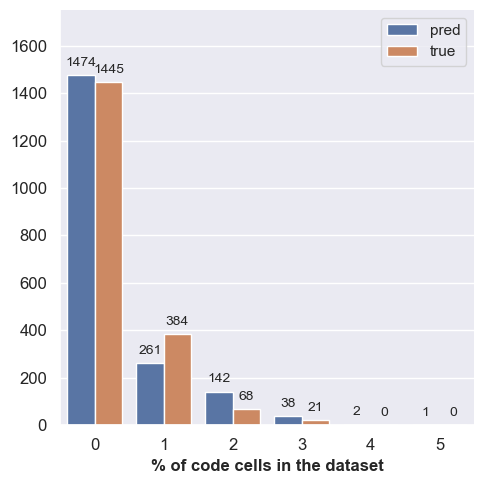

In [264]:
sns.set(rc={'figure.figsize':(9,3)})
g = sns.catplot(y = '% distribution', x ='no of labels', hue='type', data=plot, kind='bar',legend=False)    
title = "Labels per cell"
for ax in g.axes.ravel():
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width()-0.2,p.get_y()+p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=10)
#ax.xaxis.grid(False)
ax.set_xlabel("% of code cells in the dataset",fontsize=12,fontweight='bold')
ax.set_ylabel("",fontsize=12,fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
#axes=plt.gca()
ax.set(ylim=(0, 1750))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(results_path+'labeldistribution.eps', format='eps')

In [261]:
dfpred = pd.DataFrame(prediction_multi,columns=labels)
dfpred['filename'] = df2.filename
dfpred.to_pickle(results_path+'prediction_multi.pkl')